In [0]:
import numpy as np
import matplotlib.pyplot as plt
import copy 
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import models

from tqdm import tqdm_notebook

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
batch_size = 4

image_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='.\data',train=True,download=True, transform = image_transforms)
val_dataset = torchvision.datasets.CIFAR10(root='.\data',train=False,download=True, transform = image_transforms)

image_datasets = {'train':train_dataset, 'val':val_dataset}
print('Length of training dataset {:.0f} and test dataset {:.0f}'.format(len(train_dataset), len(val_dataset)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

image_dataloader = {'train': train_loader, 'val': val_loader}

classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

0it [00:00, ?it/s]

100%|█████████▉| 170090496/170498071 [00:18<00:00, 6504787.21it/s]

Files already downloaded and verified
Length of training dataset 50000 and test dataset 10000


## 2. Visualize the given images in the dataset

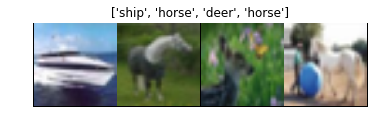

In [5]:
images,labels = next(iter(train_loader))

def display_img(img, label=None):
  img = np.transpose(img.numpy(),(1,2,0))
  plt.imshow(img)
  if label is not None:
    plt.title(label)
  plt.axis('off')

display_img(torchvision.utils.make_grid(images), [classes[x.item()] for x in labels])

## 3. Pretrained Models

In [6]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
170500096it [00:30, 6504787.21it/s]                               
100%|██████████| 46827520/46827520 [00:01<00:00, 27476767.78it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [7]:
# keeping all the parameters fixed and modifying the last layer only to 10 classes

for param in resnet18.parameters():
  param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## 4. Training the model

In [0]:
resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=1, betas=(0.9, 0.999), eps=1e-08)

In [10]:
resnet18(images.to(device))

tensor([[ 0.7652,  0.6671,  0.6757, -0.0903, -0.4249,  0.0609,  0.2388, -0.1688,
         -0.2435, -0.0452],
        [ 0.2765, -0.1629,  0.5144, -0.6418, -0.3511,  0.3192, -0.5871,  0.0233,
          0.2650,  0.2350],
        [ 1.1688,  0.1710,  0.9877, -0.2149,  0.0680,  0.7789,  0.2964, -0.0100,
         -0.6418,  0.2282],
        [ 1.1498,  0.3760,  0.6226,  0.1599, -0.6241,  0.6444, -0.6956,  0.6092,
          0.2804,  0.4091]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
def train_model(model, optimizer, criterion, lr_scheduler = None, num_epochs=5):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    
    print('Epoch {}/{}'.format(epoch,num_epochs-1))
    print('-'*10)

    for phase in ['train','val']:

      if phase is 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_correct = 0.0
      for images,labels in tqdm_notebook(image_dataloader[phase], unit='Batch',total=len(image_datasets[phase])//batch_size):
        
        # feeding the images of batch size = 4

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(images)
          preds = torch.argmax(outputs,dim=1)
          loss = criterion(outputs,labels)
          
          if phase is 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss
        running_correct += torch.sum(preds==labels.data)


      epoch_loss = running_loss/len(image_datasets[phase])
      epoch_acc =  running_correct.double()/len(image_datasets[phase])

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = epoch_acc
      
    print()
    
    if lr_scheduler is not None:
      lr_scheduler.step()
      
  time_elapsed = time.time() - since
  print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed/60, time_elapsed%60))
  print('Best accuracy: {:.2f}'.format(best_acc))
  
  model.load_state_dict(best_model_wts)
  return model

trained_model = train_model(resnet18, optimizer, criterion)

Epoch 0/4
----------



train Loss: 83.5428 Acc: 0.5278



val Loss: 59.1155 Acc: 0.7035

Epoch 1/4
----------



train Loss: 90.0819 Acc: 0.5644



val Loss: 58.7091 Acc: 0.7134

Epoch 2/4
----------



train Loss: 90.4616 Acc: 0.5697



val Loss: 61.7295 Acc: 0.7076

Epoch 3/4
----------



train Loss: 92.9296 Acc: 0.5708



val Loss: 66.1568 Acc: 0.6912

Epoch 4/4
----------



train Loss: 91.3736 Acc: 0.5759



val Loss: 59.3965 Acc: 0.7203

Training complete in: 12m 39s
Best accuracy: 0.72


correct labels: ['cat', 'ship', 'ship', 'airplane']


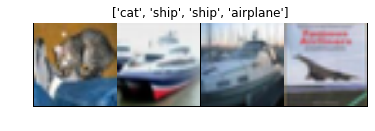

In [0]:
def visualize_prediction(model):
  images, labels = next(iter(image_dataloader['val']))
  preds = torch.argmax(model(images.to(device)),dim=1)

  display_img(torchvision.utils.make_grid(images), [classes[x.item()] for x in preds])
  print('correct labels:',[classes[x.item()] for x in labels])
  
visualize_prediction(trained_model)

## 5. Applying learning rate scheduler - StepLR

**Applying learning rate scheduler**

https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/

In [0]:
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
trained_model_2 = train_model(resnet18, optimizer, criterion, lr_scheduler)

Epoch 0/4
----------



train Loss: 91.5506 Acc: 0.5767



val Loss: 76.4988 Acc: 0.6572

Epoch 1/4
----------



train Loss: 46.0672 Acc: 0.6570



val Loss: 31.4230 Acc: 0.7492

Epoch 2/4
----------



train Loss: 34.5649 Acc: 0.6677



val Loss: 29.0817 Acc: 0.7513

Epoch 3/4
----------



train Loss: 33.2913 Acc: 0.6717



val Loss: 27.6614 Acc: 0.7607

Epoch 4/4
----------



train Loss: 32.7619 Acc: 0.6706



val Loss: 27.7591 Acc: 0.7606

Training complete in: 12m 40s
Best accuracy: 0.76


correct labels: ['cat', 'ship', 'ship', 'airplane']


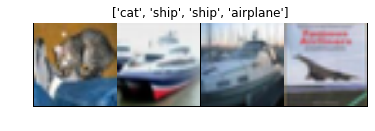

In [0]:
visualize_prediction(trained_model_2)